In [1]:
import firebase_admin
import pandas as pd
import numpy as np
from firebase_admin import credentials, firestore
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

cred = credentials.Certificate("adminkey.json")
firebase_admin.initialize_app(cred)
db = firestore.client()

INCLUDE_ONLY = ['55555']
ACTIVITIES = ['sit', 'walk', 'stairs']
SAMPLING_RATE = 100
OVERLAP = 0.5
CHUNK_SIZE = 1
DIFF_THRESHOLD = 35

In [2]:
def fetch_data_by_treatment(treatment_filter):
    data_raw, docs = [], []
    data_ref = db.collection("data").document(treatment_filter)
    for patient_id in INCLUDE_ONLY:
        subject_ref = data_ref.collection(patient_id)
        for activity in ACTIVITIES:
            activity_ref = subject_ref.document(activity)
            phone_location_col = activity_ref.collections()
            for phone_location in phone_location_col:
                for recording in phone_location.stream():
                    record = recording.to_dict()
                    if 'acceleration' not in record:
                        continue
                    df = pd.DataFrame(record['acceleration'])
                    timestamps = df['timestamp']
                    min_time = timestamps.min()
                    max_time = timestamps.max()
                    df = df[(timestamps >= min_time + 2500) & (timestamps <= max_time - 2500)]
                    if df.empty:
                        continue
                    combined = pd.DataFrame({
                        'ax': df['accelerometer'].apply(lambda x: x['x']),
                        'ay': df['accelerometer'].apply(lambda x: x['y']),
                        'az': df['accelerometer'].apply(lambda x: x['z']),
                        'gx': df['gyroscope'].apply(lambda x: x['x']),
                        'gy': df['gyroscope'].apply(lambda x: x['y']),
                        'gz': df['gyroscope'].apply(lambda x: x['z']),
                    })
                    data_raw.append(combined)
                    docs.append({'activity': activity})
    return data_raw, docs

def chunk_and_extract_features(data_raw, docs, chunk_size_sec, sampling_rate, overlap=OVERLAP):
    features, labels = [], []
    chunk_samples = int(chunk_size_sec * sampling_rate)
    step = int(chunk_samples * (1 - overlap))
    for i, df in enumerate(data_raw):
        for start in range(0, len(df) - chunk_samples + 1, step):
            chunk = df.iloc[start:start + chunk_samples]
            feats = []
            for col in chunk.columns:
                feats.extend([
                    chunk[col].mean(), chunk[col].std(), chunk[col].min(), chunk[col].max(), chunk[col].median()
                ])
            features.append(feats)
            labels.append(ACTIVITIES.index(docs[i]['activity']))
    return np.array(features), np.array(labels)

In [3]:
def train_and_test_knn():
    before_raw, before_docs = fetch_data_by_treatment('BeforeTreatment')
    X_train_full, y_train_full = chunk_and_extract_features(before_raw, before_docs, CHUNK_SIZE, SAMPLING_RATE, OVERLAP)

    after_raw, after_docs = fetch_data_by_treatment('AfterTreatment')
    X_test, y_test = chunk_and_extract_features(after_raw, after_docs, CHUNK_SIZE, SAMPLING_RATE, OVERLAP)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_full)
    X_test_scaled = scaler.transform(X_test)

    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(X_train_scaled, y_train_full)

    train_acc = knn.score(X_train_scaled, y_train_full) * 100
    y_pred = knn.predict(X_test_scaled)
    test_acc = accuracy_score(y_test, y_pred) * 100

    print(f"Train Accuracy: {train_acc:.2f}% | Test Accuracy (AfterTreatment): {test_acc:.2f}%")
    print(classification_report(y_test, y_pred, target_names=ACTIVITIES))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=ACTIVITIES, yticklabels=ACTIVITIES)
    plt.title('KNN Test Confusion Matrix')
    plt.show()

    acc_diff = abs(train_acc - test_acc)
    if acc_diff >= DIFF_THRESHOLD:
        print(f"Train-Test accuracy differs by {acc_diff:.2f}%, exceeds threshold. Data is different before vs after.")
    else:
        print(f"Train-Test accuracy differs by only {acc_diff:.2f}%, within threshold. Data is similar before vs after.")

Train Accuracy: 95.00% | Test Accuracy (AfterTreatment): 58.96%
              precision    recall  f1-score   support

         sit       1.00      0.66      0.80        74
        walk       0.49      0.48      0.48        98
      stairs       0.49      0.66      0.56        79

    accuracy                           0.59       251
   macro avg       0.66      0.60      0.61       251
weighted avg       0.64      0.59      0.60       251



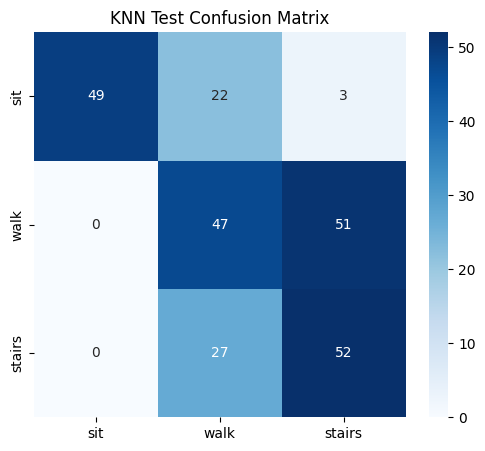

Train-Test accuracy differs by 36.04%, exceeds threshold. Data is different before vs after.


In [5]:
if __name__ == "__main__":
    train_and_test_knn()